<h1> Predicting movie earnings (Coursera Capstone Project) </h1>
October 2019

<h3> 1. Data collection </h3>

In [1]:
#import libraries
import requests # library to handle requests to websites
from bs4 import BeautifulSoup #library to get wikipedia content
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<b> 1.1 Scrap the most successful movies per year from Box Office Mojo </b>

In [ ]:
#a function which downloads the chart for each year
def scrap_boxoffice_mojo(year):
    #boxoffice mojo website to get the chart. parameter is year
    website_url = 'https://www.boxofficemojo.com/yearly/chart/?yr={}&p=.htm'.format(year)
    
    #create requets object
    result = requests.get(website_url).text
    
    #create Beautifulsoup object
    soup = BeautifulSoup(result, 'lxml')
    
    #get the table which contains the chart
    chart = soup.find('table', {'bgcolor':'#ffffff'})
    
    #split the chart in lines
    table = chart.find_all('td')
    
    #intialize lists, where the chart will be coppied
    rank = []
    title = []
    studio = []
    total = []
    total_theathres = []
    opening = []
    opening_theathres = []
    open_list = []
    close_list = []
    
    #extract the contents of the table 1-100 positions
    for i in range(8,len(table)-24,9):
        rank.append(table[i].get_text())
        title.append(table[i+1].get_text())
        studio.append(table[i+2].get_text())
        total.append(table[i+3].get_text())
        total_theathres.append(table[i+4].get_text())
        opening.append(table[i+5].get_text())
        opening_theathres.append(table[i+6].get_text())
        open_list.append(table[i+7].get_text())
        close_list.append(table[i+8].get_text())
    
    chart_df = pd.DataFrame(zip([year]*100, rank, title, studio, total, total_theathres, opening, opening_theathres, open_list, close_list), columns = ['Year', 'Rank', 'Title', 'Studio', 'Total', 'Total_theathres', 'Opening', 'Opening_theathres', 'Open', 'Close'])
    
    return chart_df

In [ ]:
#scrap top charts per year
total_chart = pd.DataFrame(columns = ['Year', 'Rank', 'Title', 'Studio', 'Total', 'Total_theathres', 'Opening', 'Opening_theathres', 'Open', 'Close'])
for year in range(2010,2019): #get most profitable movies for years 2010-2019
    chart_df = scrap_boxoffice_mojo(year)
    total_chart = total_chart.append(chart_df, ignore_index=True)

Initial data cleaning

In [ ]:
#Clean the results
#Split the title, if it contains release year
new = total_chart['Title'].str.split('(', expand = True)
total_chart['Title'] = new[0].str.strip()
total_chart['Year_release'] = new[1].str.replace(')', '')

#remove 3D from Year_release
for index, row in total_chart.iterrows():
    if row['Year_release'] != None:
        if '3D' in row['Year_release']:
            row['Year_release'] = 0
        else:
            pass
    elif row['Year_release'] == None:
        row['Year_release'] = row['Year']

In [ ]:
#convert string to number
total_chart['Year_release'] = pd.to_numeric(total_chart['Year_release'])

The result is total_chart dataframe with film title and opening earnings

<b> 1.2 Get movie details for each title from IMDB </b>

In [ ]:
#import libraries
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [ ]:
#create a list where the movie information will be stored
movie_info = []

In [ ]:
#iterate through the movies and get movie details from IMDB
for index, row in total_chart.iterrows():
    #create url, use imdb api to get movies details
    url = 'http://www.omdbapi.com/?t={}&apikey=450e01e4&y={}&plot=full'.format(row['Title'], row['Year_release'])
    
    #info from IMDB
    try:
        results = requests.get(url).json()
    
        #append to list
        movie_info.append([(results['Title'],
                            results['Year'],
                            results['Actors'],
                            results['Awards'],
                            results['Country'],
                            results['Director'],
                            results['Genre'],
                            results['Language'],
                            results['Metascore'],
                            results['Plot'],
                            results['Production'],
                            results['Rated'],
                            results['Ratings'],
                            results['Released'],
                            results['Runtime'],
                            results['Writer'],
                            results['imdbID'],
                            results['imdbRating'],
                            results['imdbVotes'])])
    except:
        movie_info.append([('','','','','','','','','','','','','','','','','','','')])
    
    print(row['Title'])
    

In [ ]:
#create dataframe with the results
movie_details = pd.DataFrame([item for movie_list in movie_info for item in movie_list])
movie_details.columns = ['Title',
                         'Year',
                         'Actors',
                         'Awards',
                         'Country',
                         'Director',
                         'Genre',
                         'Language',
                         'Metascore',
                         'Plot',
                         'Production',
                         'Rated',
                         'Ratings',
                         'Released',
                         'Runtime',
                         'Writer',
                         'imdbID',
                         'imdbRating',
                         'imdbVotes']

In [ ]:
movie_details.rename(columns={"Title": "Title_imdb", "Year": "Year_imdb"}, inplace=True)

In [ ]:
movie_details.to_csv('02movies_details.csv')

The result is movie_details dataframe.

Combine the information in one dataframe from total_chart + movie_details

In [ ]:
total_chart_desc = pd.concat([total_chart, movie_details], axis=1, sort=False)

45 movie titles did not match, therefore I manually correct the titles and do the combination again

In [ ]:
#not all titles were found (45 missing), therefore I make search again with alternative titles
movies_notconfirmed = total_chart_desc[total_chart_desc['Title_imdb'].isna()]
movies_notconfirmed.drop(['Title_imdb', 'Year_imdb', 'Actors', 'Awards', 'Country', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Production', 'Rated',
       'Ratings', 'Released', 'Runtime', 'Writer', 'imdbID', 'imdbRating',
       'imdbVotes'], inplace=True, axis=1)
movies_notconfirmed.reset_index(inplace=True)

In [ ]:
alternative_titles = ['Jackass',
 "Why Did I Get Married Too?",
 'Hubble',
 'Step Up',
 'Love & Other Drugs',
 'Daybreakers',
 'Gnomeo & Juliet',
 'Lion King',
 'Insidious',
 "Madea's Big Happy Family",
 'All the Time in the World',
 "The Avengers",
 "The Lorax",
 "Madea's Witness Protection",
 'Titanic',
 'Beauty & the Beast',
 'Star Wars',
 'Finding Nemo',
 'Monsters',
 'Bad Grandpa',
 'Witch Hunters',
 "A Madea Christmas",
 "Confessions of a Marriage Counselor",
 'Pain & Gain',
 '21 & Over',
 'Insurgent',
 'Taken',
 'Paddington',
 'Angel of Death',
 'Allegiant',
 'The Secret Soldiers of Benghazi',
 'Split',
 'John Wick',
 'Baywatch',
 "A Madea Halloween",
 'xXx',
 'Monster Trucks',
 'Blood Wars',
 'Victoria & Abdul',
 "The Grinch",
 "Ocean's Eight",
 "Christopher Robin",
 "Acrimony",
 'Paddington',
 'Holmes & Watson']

In [ ]:
#add alternative titles column in the dataframe
movies_notconfirmed['Alternative_title'] = alternative_titles

In [ ]:
#iterate through the movies and get movie details from IMDB
movie_info_notconfirmed = []

In [ ]:
for index, row in movies_notconfirmed.iterrows():
    #create url
    url = 'http://www.omdbapi.com/?t={}&apikey=450e01e4&y={}&plot=full'.format(row['Alternative_title'], row['Year_release'])
    
    #info from IMDB
    try:
        results = requests.get(url).json()
    
        #append to list
        movie_info_notconfirmed.append([(results['Title'],
                            results['Year'],
                            results['Actors'],
                            results['Awards'],
                            results['Country'],
                            results['Director'],
                            results['Genre'],
                            results['Language'],
                            results['Metascore'],
                            results['Plot'],
                            results['Production'],
                            results['Rated'],
                            results['Ratings'],
                            results['Released'],
                            results['Runtime'],
                            results['Writer'],
                            results['imdbID'],
                            results['imdbRating'],
                            results['imdbVotes'])])
    except:
        movie_info_notconfirmed.append([('','','','','','','','','','','','','','','','','','','')])
    
    print(row['Title'])

In [ ]:
#create dataframe with the results
movie_details2 = pd.DataFrame([item for movie_list in movie_info for item in movie_list])
movie_details2.columns = ['Title',
                         'Year',
                         'Actors',
                         'Awards',
                         'Country',
                         'Director',
                         'Genre',
                         'Language',
                         'Metascore',
                         'Plot',
                         'Production',
                         'Rated',
                         'Ratings',
                         'Released',
                         'Runtime',
                         'Writer',
                         'imdbID',
                         'imdbRating',
                         'imdbVotes']

In [ ]:
alternative_movies_details = pd.DataFrame()
alternative_movies_details = pd.concat((movies_notconfirmed, movie_details2), axis=1, sort=False)

The result is a dataframe with cofirmed alternative titles. Add the information in total dataframe.

In [ ]:
movies_confirmed = total_chart_desc[total_chart_desc['Title_imdb'].notna()]

In [ ]:
#check
alternative_movies_details.drop('index', axis=1, inplace=True)

In [ ]:
#check
alternative_movies_details.rename(columns={"Title": "Title_imdb", "Year": "Year_imdb"}, inplace=True)

In [ ]:
movies_confirmed = movies_confirmed.append(alternative_movies_details, sort=False, ignore_index=True)

In [ ]:
movies_confirmed.shape

In [ ]:
#Save result to a csv file
movies_confirmed.to_csv('05movies_confirmed.csv')

<b> 1.3 Get movie budget </b>

In [ ]:
#Define url with the source website
website_url = 'https://www.the-numbers.com/movie/budgets/all'
#create requets object
result = requests.get(website_url).text

In [ ]:
#create Beautifulsoup object
soup = BeautifulSoup(result, 'lxml')

In [ ]:
#From the downloaded information extract the table
table = soup.find_all('td')

In [ ]:
#Create list where the info will be stored
position = []
year_release = []
title_budget = []
budget = []
domestic_gross = []
worldwide_gross = []

In [ ]:
#create a list with pages to use for iteration
url_ext = ['']
for i in range(101,5802,100):
    url_ext.append('/'+str(i))

In [ ]:
#download the list of movies with budget
for j in url_ext:
    #Define url with the source website
    website_url = 'https://www.the-numbers.com/movie/budgets/all{}'.format(j)
    #create requets object
    result = requests.get(website_url).text
    #create Beautifulsoup object
    soup = BeautifulSoup(result, 'lxml')
    #From the downloaded information extract the table
    table = soup.find_all('td')
    
    for i in range(0, len(table)-6,6):
        position.append(table[i].get_text())
        year_release.append(str(table[i+1].get_text()).split()[-1])
        title_budget.append(table[i+2].get_text())
        budget.append(str(table[i+3].get_text()).split('$')[1])
        domestic_gross.append(str(table[i+4].get_text()).split('$')[1])
        worldwide_gross.append(str(table[i+5].get_text()).split('$')[1])

In [ ]:
#create dataframe with the result
movie_budget = pd.DataFrame(zip(position, year_release, title_budget, budget, domestic_gross, worldwide_gross), columns=['Position','Year_release_budget','Title_budget','Budget','Domestic_gross','Worldwide_gross'])

In [ ]:
#rename the Title column not to confuse with other columns
movie_budget.rename(columns={'Title_budget':'Title'}, inplace=True)

In [ ]:
movie_budget.head()

In [ ]:
#combine the information with total_chart 
merge = total_chart.merge(movie_budget, on='Title', how='left')

In [729]:
movies_confirmed_budget = pd.read_csv('12total_chart.csv')

Movies_confirmed_budget is final result database

<h3> 2. Data engineering </h3> 

<b> 2.1 Clean the data - remove unnecessary features</b>

In [730]:
movies_confirmed_budget.columns

Index(['Unnamed: 0', 'Year', 'Rank', 'Title', 'Alternative Title', 'Studio',
       'Total', 'Total_theathres', 'Opening', 'Opening_theathres', 'Open',
       'Close', 'Year_release', 'Title_imdb', 'Year_imdb', 'Actors', 'Awards',
       'Country', 'Director', 'Genre', 'Language', 'Metascore', 'Plot',
       'Production', 'Rated', 'Ratings', 'Released', 'Runtime', 'Writer',
       'imdbID', 'imdbRating', 'imdbVotes', 'Position', 'Year_release_budget',
       'Title_budget', 'Budget', 'Domestic_gross', 'Worldwide_gross'],
      dtype='object')

In [731]:
#columns to keep for analysis
features_keep = ['Year', 'Rank', 'Year', 'Opening', 'Actors', 'Country', 'Director', 'Genre', 'Language', 'Plot',
       'Production', 'Rated', 'Released', 'Runtime', 'Writer', 'Budget']

In [732]:
#columns to remove from the analysis
features_remove = ['Unnamed: 0', 'Title', 'Alternative Title', 'Studio', 'Total_theathres', 'Opening_theathres', 'Open', 'Close',
                   'Year_release', 'Title_imdb', 'Year_imdb', 'Awards', 'Metascore', 'Ratings', 'imdbID', 'imdbRating',
                   'imdbVotes', 'Position', 'Year_release_budget', 'Title_budget', 'Domestic_gross', 'Worldwide_gross']

In [733]:
#create a new dataframe to manipulate the data
movies_model = movies_confirmed_budget.copy()

In [734]:
#remove the unnecessary features
movies_model.drop(columns=features_remove, axis=1, inplace=True)

In [735]:
movies_model.columns

Index(['Year', 'Rank', 'Total', 'Opening', 'Actors', 'Country', 'Director',
       'Genre', 'Language', 'Plot', 'Production', 'Rated', 'Released',
       'Runtime', 'Writer', 'Budget'],
      dtype='object')

In [736]:
#remove rows with missing data
movies_model.dropna(axis=0, how='any', inplace=True)
movies_model.reset_index(inplace=True)

<b> 2.2 Re-work each feature </b>

In [737]:
movies_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 17 columns):
index         842 non-null int64
Year          842 non-null int64
Rank          842 non-null int64
Total         842 non-null object
Opening       842 non-null object
Actors        842 non-null object
Country       842 non-null object
Director      842 non-null object
Genre         842 non-null object
Language      842 non-null object
Plot          842 non-null object
Production    842 non-null object
Rated         842 non-null object
Released      842 non-null object
Runtime       842 non-null object
Writer        842 non-null object
Budget        842 non-null object
dtypes: int64(3), object(14)
memory usage: 111.9+ KB


2.2.1 Opening - target value

In [738]:
#Change from strin gto number and remove $ sign
movies_model['Opening'] = [str(item).replace(',','') for item in list(movies_model['Opening'])]
movies_model['Opening'] = [int(str(item).replace('$','')) for item in list(movies_model['Opening'])]

In [739]:
import seaborn as sns

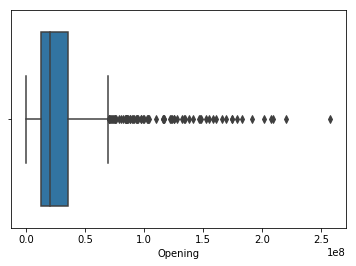

In [740]:
sns.boxplot(x=movies_model['Opening'])
plt.show()

In [741]:
print('Average opening earning is {0:8.0f} USD'.format(movies_model['Opening'].mean()))
print('with standard deviation of {0:8.0f} USD'.format(movies_model['Opening'].std()))

Average opening earning is 30795712 USD
with standard deviation of 33313172 USD


Text(0.5,1,'Opening destribution with outliers')

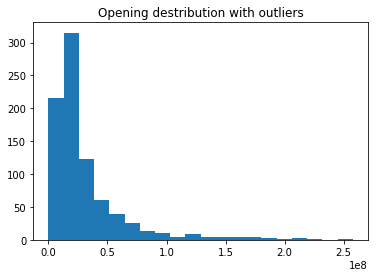

In [742]:
plt.hist(movies_model['Opening'], bins=20)
plt.title('Opening destribution with outliers')

In [743]:
print("The earning range in min {} to max {} USD".format(min(movies_model['Opening']), max(movies_model['Opening'])))
print("{0:2.0f} % of movies earn less than 50mln USD$ in Opening period".format((531+184)/842*100))

The earning range in min 31610 to max 257698183 USD
85 % of movies earn less than 50mln USD$ in Opening period


Eliminate outliers using standard deviation (99.7% of result fall in 3 standard deviation values from the mean)

In [744]:
limit = min(movies_model['Opening'])+3*movies_model['Opening'].std()

In [745]:
movies_model_original = movies_model.copy()

In [746]:
movies_model = movies_model[movies_model['Opening'] < limit]
movies_model.reset_index(inplace=True)

Text(0.5,1,'Opening destribution without outliers')

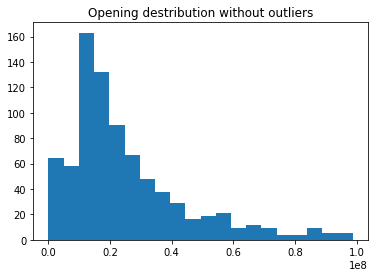

In [747]:
#Distribution after removing outliers
plt.hist(movies_model['Opening'], bins=20)
plt.title('Opening destribution without outliers')

2.2.2 Year

In [748]:
movies_model.groupby('Year').count().Opening

Year
2010    93
2011    93
2012    86
2013    92
2014    94
2015    85
2016    89
2017    86
2018    84
Name: Opening, dtype: int64

The amount of titles for each year is evently spread data - keep as is

Text(0.5,1,'Average movie earnings per year')

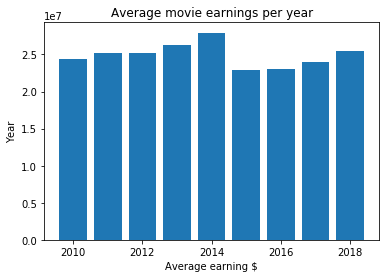

In [749]:
plt.bar(movies_model.groupby('Year').mean().Opening.index, movies_model.groupby('Year').mean().Opening.values)
plt.xlabel('Average earning $')
plt.ylabel('Year')
plt.title('Average movie earnings per year')

Remove 'Year'. The expectation was in increases with years, but this assumptino is not confirmed.

2.2.3 Released - Keep only month

In [750]:
#Convert month to number
movies_model['Released'] = [item[3:6] for item in list(movies_model['Released'])]

In [751]:
months_dict = {'Apr':4, 'Aug':8, 'Dec':12, 'Feb':2, 'Jan':1, 'Jul':7, 'Jun':6, 'Mar':3, 'May':5, 'Nov':11, 'Oct':10, 'Sep':9}
movies_model['Released'] = movies_model['Released'].replace(months_dict)

In [752]:
import seaborn as sns

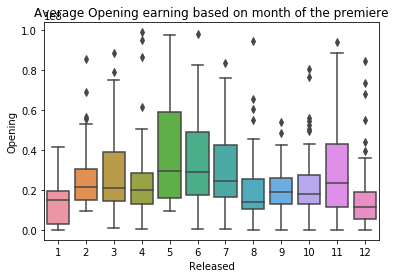

In [753]:
sns.boxplot(x='Released', y='Opening', data=movies_model)
plt.title('Average Opening earning based on month of the premiere')
plt.show()

There is a little variation in earnings depending on the month the movie was released. Months May-Jul report higher profits.

2.2.4 Runtime - convert to number

In [754]:
#Remove min and convert to integer
movies_model['Runtime'] = [int(str(item).replace(' min','')) for item in list(movies_model['Runtime'])]

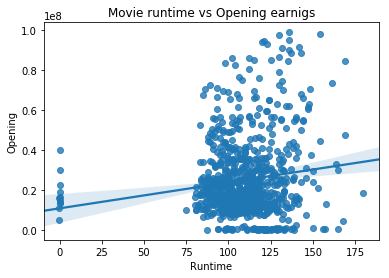

In [755]:
sns.regplot(x='Runtime', y='Opening', data=movies_model, x_jitter=.05)
plt.title('Movie runtime vs Opening earnigs')
plt.show()

There is no linear relation between the movie length and earning.

2.2.5 Budget

In [756]:
#Replace coma and convert to integer
movies_model['Budget'] = [int(str(item).replace(',','')) for item in list(movies_model['Budget'])]

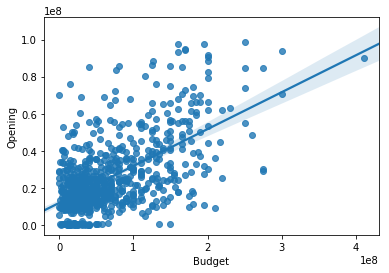

In [757]:
sns.regplot(x='Budget', y='Opening', data=movies_model, x_jitter=.05)
plt.show()

2.2.6 Categorical variables: Actors, Country, Director, Genre, Language, Rated, Writer

Clean the contents

In [758]:
def feature_fix(text):
    list_all = [item.split('(')[0].strip() for item in text.split(',')]
    result = ', '.join(list_all)
    return result

In [759]:
movies_model['Director'] = movies_model.apply(lambda x: feature_fix(x['Director']), axis=1)
movies_model['Language'] = movies_model.apply(lambda x: feature_fix(x['Language']), axis=1)
movies_model['Writer'] = movies_model.apply(lambda x: feature_fix(x['Writer']), axis=1)

In [760]:
#The film studio names are not consistent, therefore need modification
production_translate = {'A24 Films':'A24',
                        'FilmDistrict':'Film District',
                        'Fox Searchlight Pictures':'Fox Searchlight',
                        'Liongate Films':'Lionsgate Films',
                        'LionsGate Entertainment':'Lionsgate Films',
                        'Lionsgate':'Lionsgate Films',
                        'Lionsgate Pictures':'Lionsgate Films',
                        'Lionsgate and CBS Films':'Lionsgate Films',
                        'Lionsgate and Roadside Attractions':'Lionsgate Films',
                        'Paramount':'Paramount Pictures',
                        'STXfilms':'STX Films',
                        'Summit Entertainment.':'Summit Entertainment',
                        'Warner Bros Pictures':'Warner Bros.',
                        'Warner Bros. Pictures':'Warner Bros.',
                        'PIXAR':'Pixar',
                        'Walt Disney Animation Studios':'Disney',
                        'Walt Disney Pictures':'Disney',
                        'Walt Disney Studios':'Disney',                        
                        'Paramount Studios':'Paramount Pictures',
                        'Universal Pictures':'Universal',
                        'Universal Classics':'Universal',
                        'Universal Studios':'Universal',
                        'DreamWorks Animation':'Dreamworks',
                        'DreamWorks Studios':'Dreamworks',
                        'DreamWorks Pictures':'Dreamworks',
                        'Dreamworks Pictures':'Dreamworks',
                        'DWA':'Dreamworks',
                        'FilmDistrict':'Film District',
                        'TriStar Pictures':'Tristar',
                        'TriStar':'Tristar',
                        'The Weinstein Company':'The Weinstein Co.', 
                        'Sony Films':'Sony',
                        'Sony Pictures':'Sony',
                        'Sony Pictures Animation':'Sony',
                        'Sony Pictures Classics':'Sony',
                        'Sony Pictures Columbia':'Sony',
                        'Sony Pictures Releasing':'Sony',
                        'Sony Screen Gems':'Sony',
                        'Fox Searchlight Pictures, Film4 and Waypoint':'Fox Searchlight'}

In [761]:
#Create a function that translates production in list and corrects studios names
def production_fix(production):
    production_split = production.split('/')
    production_cleaned = []
    for i in production_split:
        if i in production_translate.keys():
            production_cleaned.append(production_translate.get(i))
        else:
            production_cleaned.append(i)
    final = ', '.join(production_cleaned)
    return final

In [762]:
#Apply the function
movies_model['Production'] = movies_model.apply(lambda x: production_fix(x['Production']), axis=1)

Create a function to one hot encode the categorical variables. The reason I create my own function is: the columns contain list of names, therefore I first split the names and only after do the encoding.

In [592]:
def onehot_function(column):
    #List all possible entries in a columnn
    list_all = list(movies_model[column].unique())
    
    #Split the entries in case there are multiple items
    list_all_split = []
    for group in list_all:
        try:
            [list_all_split.append(item) for item in group.split(', ')]
        except:
            list_all_split.append(group) #in case it is a single item already
            
    #
    list_all_split = set(list_all_split)
    list_all_split_cleaned = [item for item in list_all_split if type(item) == str]
    
    #Create dataframe where the data will be stored
    column_np = np.zeros(shape=(movies_model.shape[0],len(list_all_split_cleaned)))
    column_df = pd.DataFrame(columns=list_all_split_cleaned)
    column_df = pd.DataFrame(column_np, columns=list_all_split_cleaned)
    
    #Iterate through dataframe
    for index, row in movies_model.iterrows():
        for item in list_all_split_cleaned:
            if item in row[column]:
                column_df.at[index, item] = 1
            else:
                column_df.at[index, item] = 0
                
    return column_df

In [57]:
#encode categorical feature
actors_df = onehot_function('Actors')
country_df = onehot_function('Country')
director_df = onehot_function('Director')
genre_df = onehot_function('Genre')
language_df = onehot_function('Language')
writer_df = onehot_function('Writer')
rated_df = onehot_function('Rated')
production_df = onehot_function('Production')
released_df = onehot_function('Released')

In [593]:
genre_df = onehot_function('Genre')
rated_df = onehot_function('Rated')
released_df = onehot_function('Released')

In [58]:
#add to movies_model dataframe
movies_model[actors_df.columns] = actors_df
movies_model[country_df.columns] = country_df
movies_model[director_df.columns] = director_df
movies_model[genre_df.columns] = genre_df
movies_model[language_df.columns] = language_df
movies_model[rated_df.columns] = rated_df
movies_model[writer_df.columns] = writer_df
movies_model[production_df.columns] = production_df
movies_model[released_df.columns] = released_df

In [705]:
movies_model[genre_df.columns] = genre_df
movies_model[rated_df.columns] = rated_df
movies_model[released_df.columns] = released_df

2.2.7 Plot

Plot is a short story that summarizes the script of the film. The problem is how to use it in machine learning.

In [63]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

In [64]:
#Get the list of word from each Plot. Remove stopwords and punctuation
#The result is stored in plot_strip column
def strip_plot(text):
    word_list = word_tokenize(text)
    word_list_strip = [word.lower() for word in word_list if word.lower() not in stopwords.words() and word.isalpha()]
    return word_list_strip

In [65]:
movies_model['Plot_strip'] = movies_model.apply(lambda x: strip_plot(x['Plot']), axis=1)

In [67]:
#Make a list of all words
all_words = list(movies_model['Plot_strip'])

In [68]:
#Define a function that removes nested list
#Result is a list of words from each plot
output = []
def remove_nested_list(l): 
    for i in l: 
        if type(i) == list: 
            remove_nested_list(i) 
        else: 
            output.append(i) 
    return output

In [69]:
#Apply nested function
all_words_list = remove_nested_list(all_words)

In [71]:
print('The result is a list of ', len(all_words_list), ' words.')
print('The number of unique words is ', len(set(all_words_list)))

The result is a list of  38229  words.
The number of unique words is  9814


In [ ]:
#most_common_words = [word[0] for word in FreqDist(all_all_words_onelist).most_common(100)]

In [72]:
#Create a database to count word frequency
words_count = pd.DataFrame(np.zeros(shape=(len(set(all_words_list)),2)), columns=['word','freq'])
words_count['word'] = list(set(all_words_list))

In [73]:
#Iterate through the Plots and count words
for indexplot, rowplot in movies_model.iterrows():
    for indexword, rowword in words_count.iterrows():
        if rowword['word'] in rowplot['Plot_strip']:
            words_count.at[indexword, 'freq'] += 1

In [74]:
print('The most common words are:')
words_count.sort_values('freq', ascending=False).head(10)

The most common words are:


,word,freq
8259,world,157.0
1370,one,156.0
9184,life,154.0
3637,new,149.0
4519,find,139.0
3106,must,131.0
1159,family,108.0
5744,get,104.0
7038,years,102.0
5925,help,100.0


Select words which appear in Plot at least 15 times. Create a data frame with their presence for each title

In [81]:
#Create a list of words which frequency is >=15
most_common_words = words_count['word'][words_count['freq']>2]

In [82]:
len(most_common_words)

2733

In [83]:
#One hot encoding. Create a blank dataframe
most_common_words_df = pd.DataFrame(np.zeros(shape=(len(movies_model['Plot']), len(most_common_words))), columns=most_common_words)

In [84]:
#Iterate through Plots and assigned 1, if the Plot contains most common word
for indexplot, wordplot in movies_model.iterrows():
    for wordword in most_common_words:
        if wordword in wordplot['Plot_strip']:
            most_common_words_df.at[indexplot, wordword] = 1

In [596]:
movies_model[most_common_words_df.columns] = most_common_words_df

In [87]:
movies_model.columns[0:30]

Index(['level_0', 'index', 'Year', 'Rank', 'Total', 'Opening', 'Actors',
       'Country', 'Director', 'Genre', 'Language', 'Plot', 'Production',
       'Rated', 'Released', 'Runtime', 'Writer', 'Budget', 'Kevin Guthrie',
       'Shailene Woodley', 'Riley Thomas Stewart', 'Alex Kendrick',
       'Henry Cavill', 'Devon Bostick', 'Patrick St. Esprit', 'Sophie Stuckey',
       'Aidy Bryant', 'Omar Sy', 'Zachary Bailess', 'Stephanie Beatriz'],
      dtype='object')

<b> 2.3 Prepare input table for machine learning </b>

Remove columns which were one hot encoded

In [708]:
#Define columns to be removed
columns_to_remove = ['level_0', 'index', 'Year', 'Rank', 'Total', 'Actors', 'Country', 'Director', 'Genre',  'Language', 'Plot', 'Production', 'Rated', 'Writer', 'Released']columns_to_remove = ['level_0', 'index', 'Year', 'Rank', 'Total', 'Actors', 'Country', 'Director', 'Genre',  'Language', 'Plot', 'Plot_strip', 'Production', 'Rated', 'Writer', 'Released']

In [709]:
#Remove columns
movies_model.drop(columns_to_remove, axis=1, inplace=True)

In [92]:
#Save to csv
movies_model.to_csv('model_input.csv')

<h3> 3. Modelling </h3>

<b> 3.1 Create train and test data </b>

Split data

In [95]:
from sklearn.model_selection import train_test_split

In [710]:
target = movies_model['Opening']

In [711]:
movies_model.drop('Opening', axis=1, inplace=True)

In [712]:
X_train, X_test, y_train, y_test = train_test_split(movies_model, target, random_state=0, train_size=0.9)

Scale data

In [100]:
from sklearn.preprocessing import MinMaxScaler

In [713]:
scaler = MinMaxScaler()
scaler.fit(X_train[['Runtime', 'Budget']])
X_train[['Runtime', 'Budget']] = scaler.transform(X_train[['Runtime', 'Budget']])

C:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tomas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [714]:
X_test[['Runtime', 'Budget']] = scaler.transform(X_test[['Runtime', 'Budget']])

C:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\tomas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<b> 3.2 Linear regression </b>

In [107]:
from sklearn.linear_model import LinearRegression

In [531]:
lr = LinearRegression().fit(X_train, y_train)

In [532]:
lr.score(X_train, y_train)

0.8207566093404185

In [533]:
lr.score(X_test, y_test)

-1.840526381606688e+25

Linear regression does not work well

<b> 3.3 Decision tree </b>

In [111]:
from sklearn.tree import DecisionTreeRegressor

In [207]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=2, splitter='random')

In [208]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='random')

In [209]:
tree.score(X_train, y_train)

0.23842916782076795

In [210]:
tree.score(X_test, y_test)

0.18554539843090467

Decision tree regression does not work well

<b> 3.4 Stochastic Gradient Descent </b>

In [211]:
from sklearn import linear_model

In [236]:
clf = linear_model.SGDRegressor(max_iter=100, tol=10)
clf.fit(X_train, y_train)

C:\Users\tomas\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=100, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=10, verbose=0,
       warm_start=False)

In [237]:
clf.score(X_train, y_train)

0.9818339439589961

In [238]:
clf.score(X_test, y_test)

0.29512683007912976

The result is better, but still overfitting

<b> 3.5 Neural network </b>

In [239]:
from sklearn.neural_network import MLPRegressor

In [240]:
mlp = MLPRegressor(solver='lbfgs', random_state=0, alpha=0.001, hidden_layer_sizes=[10,10]).fit(X_train, y_train)

In [241]:
mlp.score(X_train,y_train)

0.997602514558085

In [242]:
mlp.score(X_test, y_test)

0.21737011495110947

Overfitting. Requires parameter tuning.

<b> 3.6 Gradient Boosting </b>

In [292]:
from sklearn.ensemble import GradientBoostingRegressor

In [300]:
gbrt=GradientBoostingRegressor(n_estimators=100)

In [301]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [451]:
gbrt.score(X_train, y_train)

0.6719015408313063

In [452]:
gbrt.score(X_test, y_test)

0.43598069744003193

Most consisten resuly, but still not satisfactory.

In [446]:
import seaborn as sns

In [453]:
ybar = gbrt.predict(X_test)

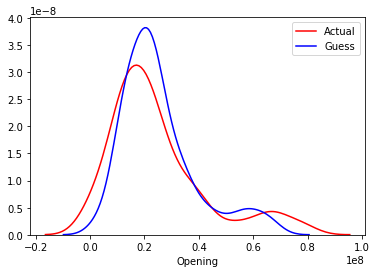

In [454]:
ax1 = sns.distplot(y_test, hist=False, color='r', label='Actual')
sns.distplot(ybar, hist=False, color='b', label='Guess', ax=ax1)

<b> 3.7 Support Vector Machine</b>

In [507]:
from sklearn.svm import SVC

In [527]:
clf = SVC(C= 0.1, kernel='rbf', gamma='auto')

In [528]:
clf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [529]:
clf.score(X_train, y_train)

1.0

In [530]:
clf.score(X_test, y_test)

0.0

<h1> 4. Example of prediction </h1>

In [721]:
ybar = gbrt.predict(X_test)

In [726]:
ybar[0:3]

array([15734224.65631003, 27278085.8718708 , 24447134.9512056 ])

In [727]:
y_test[0:3]

8      24830443
253    21052227
85     10609795
Name: Opening, dtype: int64

In [769]:
genres_df = pd.DataFrame(genres_np, columns=['Genre', 'Profit'])
genres_df['Genre'] = genres